In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_31056\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


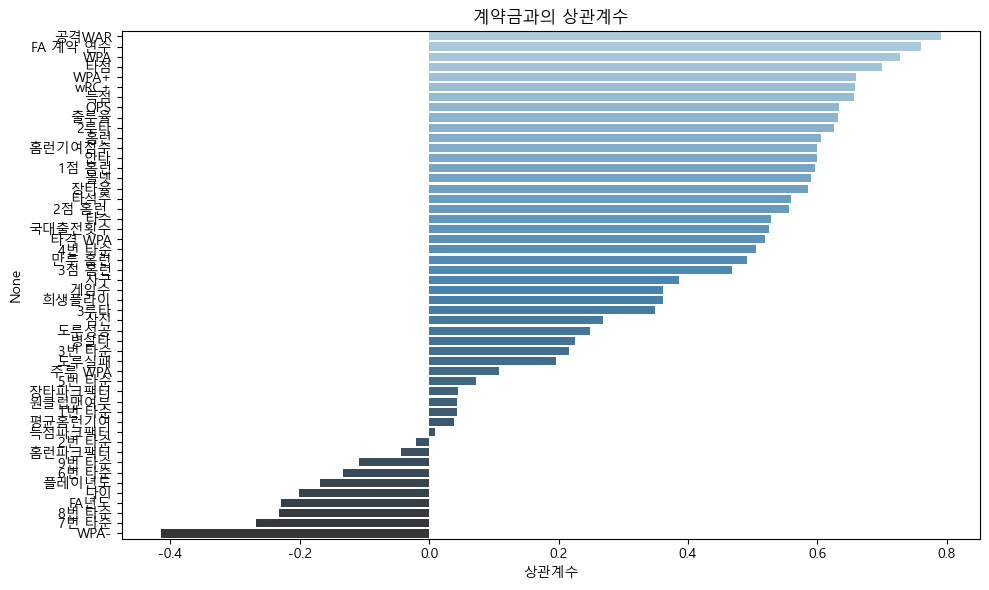

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝 (XGBoost)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 500]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 15:45:30,168] A new study created in memory with name: no-name-ab6706f1-76cb-4141-bd4f-0239de7acdac
[I 2025-08-06 15:45:30,535] Trial 0 finished with value: 116887.11158535097 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2020372855464486, 'subsample': 0.6360366028126353, 'colsample_bytree': 0.9115849044977657, 'gamma': 3.9640949915666295, 'min_child_weight': 5, 'reg_alpha': 4.573586956912582, 'reg_lambda': 2.977849345219856}. Best is trial 0 with value: 116887.11158535097.
[I 2025-08-06 15:45:31,592] Trial 1 finished with value: 113878.0900800877 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.22663632381652823, 'subsample': 0.9217379871349498, 'colsample_bytree': 0.6061273849765999, 'gamma': 1.9052634679232583, 'min_child_weight': 7, 'reg_alpha': 0.6142880668238909, 'reg_lambda': 0.6127178795368243}. Best is trial 1 with value: 113878.0900800877.
[I 2025-08-06 15:45:32,723] Trial 2 finished with value: 114597.974575690

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

print("[XGBoost + Optuna] 최적 파라미터:")
print(best_params)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred) 
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

[XGBoost + Optuna] 최적 파라미터:
{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.057354250797242656, 'subsample': 0.7158807303433045, 'colsample_bytree': 0.7609471435406943, 'gamma': 2.7953103737225407, 'min_child_weight': 2, 'reg_alpha': 2.888760162184132, 'reg_lambda': 4.85418131586572}
[모델 평가 지표]
 MSE : 20,190,392,574.03
 RMSE: 142,092.90
 MAE : 87,106.61
 R²  : 0.6050


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

C:\Users\Lee\AppData\Local\Temp\ipykernel_31056\2933799307.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (XGBoost)', palette='YlGnBu')


피처 중요도 (XGBoost + Optuna):
       컬럼명  중요도 (XGBoost)  상관계수 기반 가중치
0    공격WAR       0.159556     0.040855
17  국대출전횟수       0.157550     0.027093
4     wRC+       0.134475     0.033973
5       득점       0.078089     0.033944
8      2루타       0.039357     0.032353
7      출루율       0.038468     0.032661
27    도루성공       0.034480     0.012825
11      안타       0.033695     0.030939
2       타점       0.030997     0.036160
1      WPA       0.027860     0.037568
22      사구       0.022695     0.019909
14     장타율       0.020878     0.030230
3     WPA+       0.017583     0.034056
6      OPS       0.016694     0.032738
42      나이       0.016564     0.010384
12   1점 홈런       0.014424     0.030799
41   플레이년도       0.011141     0.008669
25     3루타       0.009973     0.018032
9       홈런       0.009248     0.031318
34  원클럽맨여부       0.009199     0.002259
30    도루실패       0.009118     0.010136
19   4번 타순       0.008928     0.026125
10  홈런기여점수       0.008495     0.030976
36  득점파크팩터       0.007233     0.00048

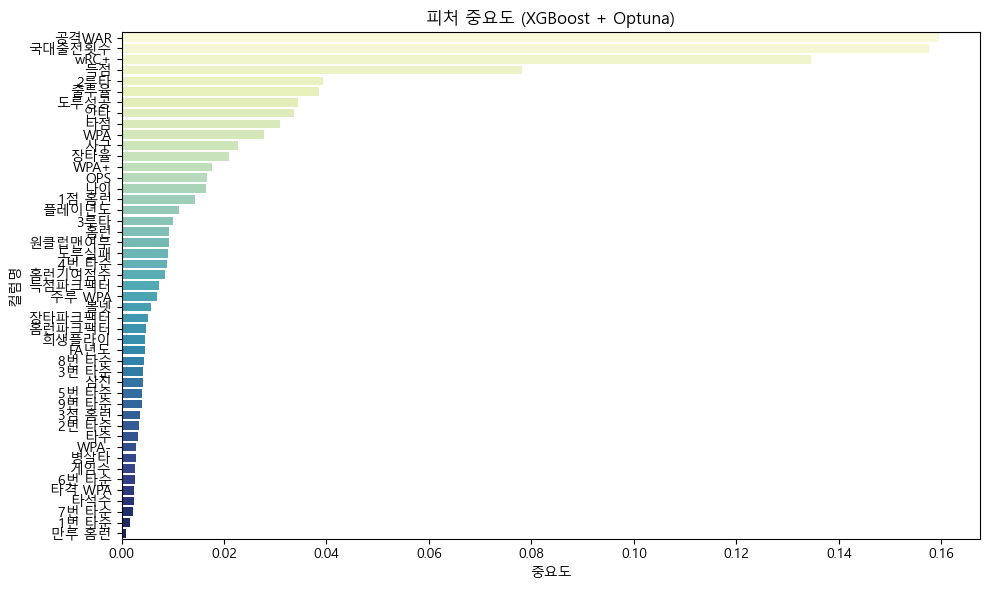

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (XGBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (XGBoost)', ascending=False)

print("피처 중요도 (XGBoost + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (XGBoost)', palette='YlGnBu')
plt.title('피처 중요도 (XGBoost + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (XGBoost + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (XGBoost + Optuna):
    선수명     계약금
0   강민호  241456
1   강백호  147700
2   김재환  204823
3   박병호  170865
4   박승욱   36987
5   박찬호  159055
6   박해민  228467
7   손아섭  170830
8   이재원   67214
9   장성우  148973
10   정훈   31191
11  조수행   39928
12  최원준  137508
13  최형우  208498
14  황재균  145242
